In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install statsmodels==0.11.1
!pip install fbprophet

     |████████████████████████████████| 8.7MB 7.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# 1. Library Import

In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
src = list(files.upload().values())[0]
open('forecasting_metrics.py','wb').write(src)
import forecasting_metrics
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import warnings
import datetime
warnings.filterwarnings("ignore")

Saving forecasting_metrics.py to forecasting_metrics (1).py


# 2. 데이터 불러오기

## 1) read_csv

In [ ]:
data_path = '/content/drive/MyDrive/dataset'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")

file = data_path + "/coin.csv"
if os.path.isfile(file):
  print("yes")  
  coin_df = pd.read_csv(data_path + "/coin.csv")
else:
  print("no")
  MAX = max(train_x_df["coin_index"]) + 1
  coin_df = pd.DataFrame(np.zeros([MAX, 2], np.int64), columns = ['coin_index', 'buy_quantity'])

  coin_df.loc[:, 'coin_index'] = coin_df.index
  coin_df.loc[:,'buy_quantity'] = 1

  coin_df.to_csv(data_path + "/coin.csv", mode = 'w')

yes


## 2) numpy arrary로 변환하기

In [ ]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [ ]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)

In [ ]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
''')


train_x_array (7661, 1380, 10)
train_y_array (7661, 120, 10)



## 3) Plot 함수

In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

# 3. 샘플 추론

## 1) 샘플 Set 가져오기

### <1> 공용 상수

In [ ]:
SAMPLE_SET_INDEX_START = 0
SAMPLE_SET_INDEX_END = 20

pred_start_id = train_x_df.sample_id.min()
pred_fin_id = train_x_df.sample_id.max()


### <2> Prophet용 Sample 데이터

In [ ]:
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

x_prophet_df = train_x_df[SAMPLE_SET_INDEX_START <= train_x_df.sample_id]
x_prophet_df = x_prophet_df[SAMPLE_SET_INDEX_END >= x_prophet_df.sample_id]
y_prophet_df = train_y_df[SAMPLE_SET_INDEX_START <= train_y_df.sample_id]
y_prophet_df = y_prophet_df[SAMPLE_SET_INDEX_END >= y_prophet_df.sample_id]


prophet_pred_array = np.zeros([(SAMPLE_SET_INDEX_END - SAMPLE_SET_INDEX_START) + 1, 120])
x_prophet_array = df2d_to_array3d(x_prophet_df)
y_prophet_array = df2d_to_array3d(y_prophet_df)

### <3> VAR용 Sample 데이터

In [ ]:
var_variables = ["open_ema30","volume_ema30","trades_ema30"]
var_variables_1d = ["open_1d","volume_1d","trades_1d"]

x_var_df = train_x_df[SAMPLE_SET_INDEX_START <= train_x_df.sample_id]
x_var_df = x_var_df[x_var_df.sample_id <= SAMPLE_SET_INDEX_END]
y_var_df = train_y_df[SAMPLE_SET_INDEX_START <= train_y_df.sample_id]
y_var_df = y_var_df[y_var_df.sample_id <= SAMPLE_SET_INDEX_END]

x_var_df['open_ema30'] = x_var_df['open'].ewm(30).mean()
x_var_df['volume_ema30'] = x_var_df['volume'].ewm(30).mean()
x_var_df['trades_ema30'] = x_var_df['trades'].ewm(30).mean()
x_var_df['open_ema30'].iloc[-1] = x_var_df['open'].iloc[-1]
x_var_df['volume_ema30'].iloc[-1] = x_var_df['volume'].iloc[-1]
x_var_df['trades_ema30'].iloc[-1] = x_var_df['trades'].iloc[-1]

var_pred_array = np.zeros([(SAMPLE_SET_INDEX_END - SAMPLE_SET_INDEX_START) + 1, 120])
x_var_array = df2d_to_array3d(x_var_df)
y_var_array = df2d_to_array3d(y_var_df)

print(x_var_df)


       sample_id  time  coin_index  ...  open_ema30  volume_ema30  trades_ema30
0              0     0           9  ...    0.983614      0.001334      0.009855
1              0     1           9  ...    0.983426      0.001380      0.013047
2              0     2           9  ...    0.983174      0.001436      0.013433
3              0     3           9  ...    0.983131      0.001720      0.015565
4              0     4           9  ...    0.983366      0.001955      0.016817
...          ...   ...         ...  ...         ...           ...           ...
28975         20  1375           1  ...    0.994663      0.861769      0.502151
28976         20  1376           1  ...    0.994734      0.883397      0.515231
28977         20  1377           1  ...    0.994833      0.895801      0.518561
28978         20  1378           1  ...    0.994929      0.959453      0.547824
28979         20  1379           1  ...    1.000000      1.184419      0.811245

[28980 rows x 15 columns]


## 2) 샘플 추론

In [ ]:
for idx in tqdm(range(0,(SAMPLE_SET_INDEX_END - SAMPLE_SET_INDEX_START) + 1)):
    # Prophet
    try:
        x_series = x_prophet_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False, changepoint_range = 0.98, changepoint_prior_scale = 0.05)

        
        prophet.add_seasonality(name='seasonality_A', period=1/12, fourier_order=7)
        prophet.add_seasonality(name='seasonality_A', period=1/8, fourier_order=14)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        prophet_pred_array[idx,:] = pred_y

        
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass
    
    #VAR
    sample_df = x_var_df.groupby("sample_id").get_group(SAMPLE_SET_INDEX_START + idx)
    sample_df_set = sample_df[var_variables]
    sample_df_set.index = sample_df["time"]

    sample_df_set = sample_df_set.diff().dropna()

    forecasting_model = VAR(sample_df_set)
    results = forecasting_model.fit(maxlags=200, ic='aic',verbose=False, trend='ctt')
    lag_order = results.k_ar

    forecast_idx = pd.Index(np.arange(120), dtype='int64', name='time', length=120)
    forecast = pd.DataFrame(results.forecast(sample_df_set.values[-lag_order:], steps=120), index=forecast_idx, columns=var_variables_1d)
    forecast["open_forecasted"] = sample_df["open"].iloc[-1] + forecast["open_1d"].cumsum()
    forecast["volume_forecasted"] = sample_df["volume_ema30"].iloc[-1] + forecast["volume_1d"].cumsum()
    forecast["trades_forecasted"] = sample_df["trades_ema30"].iloc[-1] + forecast["trades_1d"].cumsum()

    forecast_list = forecast["open_forecasted"].tolist()
    var_pred_array[idx,:] = forecast_list

    plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
    plt.plot(np.arange(1380, 1380+120), forecast_list, label = 'prediction_var')
    plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction_prophet ')
    plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_prophet_lower')
    plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_prophet_upper')
    plt.legend()
    plt.savefig(f"{data_path}/plot_history/plot_{idx + SAMPLE_SET_INDEX_START}.png")
    plt.clf()









  0%|          | 0/21 [00:00<?, ?it/s]






  5%|▍         | 1/21 [00:18<06:03, 18.17s/it]






 10%|▉         | 2/21 [00:37<05:52, 18.55s/it]






 14%|█▍        | 3/21 [00:55<05:29, 18.28s/it]






 19%|█▉        | 4/21 [01:13<05:12, 18.40s/it]






 24%|██▍       | 5/21 [01:31<04:51, 18.24s/it]






 29%|██▊       | 6/21 [01:50<04:35, 18.38s/it]






 33%|███▎      | 7/21 [02:09<04:18, 18.49s/it]






 38%|███▊      | 8/21 [02:27<03:58, 18.36s/it]






 43%|████▎     | 9/21 [02:45<03:40, 18.41s/it]






 48%|████▊     | 10/21 [03:05<03:26, 18.75s/it]






 52%|█████▏    | 11/21 [03:23<03:06, 18.63s/it]






 57%|█████▋    | 12/21 [03:41<02:45, 18.40s/it]






 62%|██████▏   | 13/21 [04:00<02:27, 18.50s/it]






 67%|██████▋   | 14/21 [04:18<02:09, 18.45s/it]






 71%|███████▏  | 15/21 [04:36<01:50, 18.37s/it]






 76%|███████▌  | 16/21 [04:55<01:31, 18.32s/it]






 81%|████████  | 17/21 [05:14<01:14, 18.58s/it]






 86%|████████▌ | 18/21 [05:32<00:55, 18

<Figure size 432x288 with 0 Axes>

### <3> valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [ ]:
def array_to_submission(prophet_pred_array, var_pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    
    submission = pd.DataFrame(np.zeros([prophet_pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'sell_time'] = 119


    for idx in range(0, prophet_pred_array.shape[0]):
      sample_df = x_var_df.groupby("sample_id").get_group(SAMPLE_SET_INDEX_START + idx)
      coin_idx = int(sample_df['coin_index'].values[0])
      coin_idx = train_x_df.loc[SAMPLE_SET_INDEX_START + idx, 'coin_index']
      if prophet_pred_array[idx, 119] > 1.0 and var_pred_array[idx, 119] > 1.0:
        submission.loc[idx, 'buy_quantity'] = coin_df.loc[coin_idx, 'buy_quantity']
      

    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    submission['sample_id'] = np.arange(SAMPLE_SET_INDEX_START,SAMPLE_SET_INDEX_END + 1)
    return submission

In [ ]:
valid_submission = array_to_submission(prophet_pred_array, var_pred_array)

In [ ]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,119
1,1,0,119
2,2,0,119
3,3,1,119
4,4,1,119
5,5,0,119
6,6,0,119
7,7,0,119
8,8,1,119
9,9,0,119


In [ ]:
valid_submission.buy_quantity.value_counts()

0    15
1     6
Name: buy_quantity, dtype: int64

### <4> 투자 후 금액 계산하기

In [ ]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_money      = 10000 # dolors
    total_money_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0] ##매수했을 때의 실제 가격(처음 0분의 실제 가격)
        sell_price = y_array[row_idx - start_index, sell_time] ##팔 때의 실제 가격(마지막 120분의 실제 가격)
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_money ##buy_quantity랑 현재 가지고 있는 토탈 머니 곱함
        residual = total_money - buy_quantity ##이전의 토탈머니와 buy_quantity값 곱해준 것과의 차이
        ratio = sell_price / buy_price ##살 때와 팔 때의 가격 차이
        pre_money = total_money
        total_money = buy_quantity * ratio * 0.9995 * 0.9995 + residual
        total_money_list.append(total_money)
        sample_df = x_var_df.groupby("sample_id").get_group(SAMPLE_SET_INDEX_START + idx)
        coin_idx = int(sample_df['coin_index'].values[0])
        if pre_money > total_money:
          coin_df.loc[coin_idx, 'buy_quantity'] = max(coin_df.loc[coin_idx, 'buy_quantity'] - (pre_money - total_money) / pre_money, 0.0)
        elif pre_money < total_money and coin_df.loc[coin_idx, 'buy_quantity'] < 1:
          coin_df.loc[coin_idx, 'buy_quantity'] = min(coin_df.loc[coin_idx, 'buy_quantity'] + (total_money - pre_money) / pre_money, 1.0)     

    print(coin_df)             
    coin_df.to_csv(data_path + "/coin.csv", mode = 'w')    
    return total_money, total_money_list

In [ ]:
total_money, total_money_list = COIN(y_prophet_df,
                                     valid_submission)

In [ ]:
# 투자 후 금액
print(total_momey)

10306.483702599156


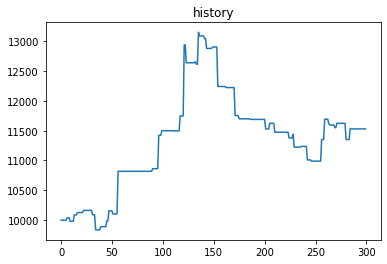

In [ ]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

# 4. test 데이터 학습하고 추론하기

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False, changepoint_range = 0.98, changepoint_prior_scale = 0.05)
        
        prophet.add_seasonality(name='seasonality_A', period=1/12, fourier_order=7)
        prophet.add_seasonality(name='seasonality_A', period=1/8, fourier_order=14)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 535/535 [56:54<00:00,  6.38s/it]


## 추론한 test_pred_array를 바탕으로 submission df 생성하기

In [ ]:
submission = array_to_submission(test_x_array, test_pred_array, pred_start_id, pred_fin_id)

In [ ]:
submission.buy_quantity.value_counts() 

0    384
1    151
Name: buy_quantity, dtype: int64

In [ ]:
submission.to_csv(data_path+"/submission5.csv", index = False)